## Individual Assignment 2 ##
### S2197634 ###

In [2]:
import numpy as np
import pandas as pd

### Task 1

In [3]:
GRAB_REVIEWS = pd.DataFrame(pd.read_csv('GRAB_REVIEWS.csv'))

#frist 5 rows
print(GRAB_REVIEWS.head(5))

#print number of rows and columns
print(GRAB_REVIEWS.shape)

#identify diff columns n data types
print(GRAB_REVIEWS.dtypes)

#missing values each column
print(GRAB_REVIEWS.isna().any())

   Unnamed: 0                                        review_text  \
0           0                                         Great app!   
1           1                                         Super like   
2           2  This app makes it easy to find a cab. Drivers ...   
3           3                                  Great experience!   
4           4                             Very convenient. Cool.   

   review_rating              author_id    author_name author_app_version  \
0              5                    NaN  A Google user                NaN   
1              5  115115*********328635  A Google user               v2.0   
2              5  106986*********228101  A Google user               v2.0   
3              5  101636*********375392  A Google user               v2.0   
4              5  115165*********970835  A Google user               v2.0   

        review_datetime_utc  review_likes  
0  2013-05-31T16:03:05.000Z             1  
1  2013-06-09T03:37:35.000Z             

### Task 2

In [4]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))

# Create a copy of the DataFrame for task 2
task2_GRAB_REVIEWS = GRAB_REVIEWS.copy()[['review_rating', 'review_text']]

[nltk_data] Downloading package stopwords to C:\Users\Khaira
[nltk_data]     Nafisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Khaira
[nltk_data]     Nafisa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#new col : sentiment
task2_GRAB_REVIEWS['sentiment'] = task2_GRAB_REVIEWS['review_rating'].apply(
    lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral')
)

In [7]:
# Text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower() # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    tokens = text.split() # Tokenize
    cleaned_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words] # Remove stop words and apply stemming
    return ' '.join(cleaned_tokens) # Join tokens back into a string

In [8]:
task2_GRAB_REVIEWS['cleaned_review_text'] = task2_GRAB_REVIEWS['review_text'].apply(clean_text)

In [9]:
print(task2_GRAB_REVIEWS.head())
print("\nSummary:")
task2_GRAB_REVIEWS.info()

   review_rating                                        review_text sentiment  \
0              5                                         Great app!  positive   
1              5                                         Super like  positive   
2              5  This app makes it easy to find a cab. Drivers ...  positive   
3              5                                  Great experience!  positive   
4              5                             Very convenient. Cool.  positive   

                                 cleaned_review_text  
0                                          great app  
1                                         super like  
2  app make easi find cab driver respect even ema...  
3                                       great experi  
4                                       conveni cool  

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441620 entries, 0 to 441619
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------  

Using stemming rather than lemmatization because:
1. It's computationally faster for this large dataset (400k++ reviews)
2. While stemming is less precise linguistically, it's sufficient for sentiment analysis
3. We're more interested in identifying patterns than preserving exact meanings

### Task 3

In [10]:
%pip install seaborn
import seaborn as sns


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#split data, training and testing
X = task2_GRAB_REVIEWS['cleaned_review_text']
y = task2_GRAB_REVIEWS['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Convert text to numerical features using TF-IDF
TF-IDF is preferred over Count Vectorizer because:
1. It downweights common words that appear in many documents
2. It gives more importance to distinctive words that help differentiate sentiments
3. It's more effective for sentiment analysis as it captures word importance

In [12]:
import matplotlib.pyplot as plt
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features to prevent overfitting
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [13]:
# Train a Multinomial Naive Bayes classifier (suitable for text classification)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
print("Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.8710

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.87      0.79     20587
     neutral       0.23      0.01      0.01      4328
    positive       0.93      0.93      0.93     63409

    accuracy                           0.87     88324
   macro avg       0.63      0.60      0.58     88324
weighted avg       0.85      0.87      0.85     88324



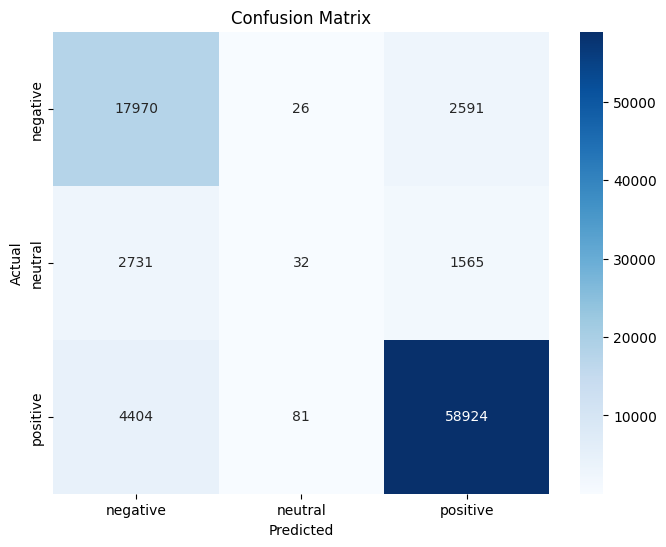

In [14]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nb_classifier.classes_, 
            yticklabels=nb_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Task 4

In [15]:
%pip install gensim pyLDAvis

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

In [17]:
positive_reviews = task2_GRAB_REVIEWS[task2_GRAB_REVIEWS['sentiment'] == 'positive']['cleaned_review_text']
negative_reviews = task2_GRAB_REVIEWS[task2_GRAB_REVIEWS['sentiment'] == 'negative']['cleaned_review_text']
neutral_reviews = task2_GRAB_REVIEWS[task2_GRAB_REVIEWS['sentiment'] == 'neutral']['cleaned_review_text']

print(f"Number of positive reviews: {len(positive_reviews)}")
print(f"Number of negative reviews: {len(negative_reviews)}")
print(f"Number of neutral reviews: {len(neutral_reviews)}")


Number of positive reviews: 317047
Number of negative reviews: 102933
Number of neutral reviews: 21640


In [23]:
def perform_topic_modeling(texts, num_topics=5):
    # Tokenize
    tokenized_texts = [text.split() for text in texts if isinstance(text, str) and len(text) > 0]
    
    # Create dictionary
    dictionary = corpora.Dictionary(tokenized_texts)
    dictionary.filter_extremes(no_below=15, no_above=0.5)
    
    # Create document-term matrix
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Train LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10
    )
    
    # Get top topics
    topics = lda_model.print_topics(num_words=10)
    
    return lda_model, corpus, dictionary, topics


In [26]:
# Perform topic modeling for each sentiment
print("\n--- POSITIVE REVIEWS TOPICS ---")
pos_lda_model, pos_corpus, pos_dictionary, pos_topics = perform_topic_modeling(positive_reviews)
for topic in pos_topics:
    print(f"Topic {topic[0]}: {topic[1]}")


--- POSITIVE REVIEWS TOPICS ---
Topic 0: 0.041*"driver" + 0.028*"deliveri" + 0.024*"time" + 0.022*"grab" + 0.015*"order" + 0.010*"rider" + 0.010*"app" + 0.009*"po" + 0.007*"book" + 0.007*"ang"
Topic 1: 0.124*"nice" + 0.023*"dan" + 0.021*"grab" + 0.018*"terbaik" + 0.015*"sangat" + 0.014*"driver" + 0.014*"di" + 0.012*"saya" + 0.011*"yg" + 0.010*"bagu"
Topic 2: 0.066*"grab" + 0.058*"thank" + 0.058*"help" + 0.052*"app" + 0.049*"food" + 0.038*"driver" + 0.036*"best" + 0.026*"love" + 0.020*"ride" + 0.019*"car"
Topic 3: 0.434*"good" + 0.138*"servic" + 0.088*"great" + 0.084*"app" + 0.053*"excel" + 0.053*"ok" + 0.025*"👍" + 0.017*"job" + 0.010*"far" + 0.009*"amaz"
Topic 4: 0.135*"use" + 0.081*"easi" + 0.071*"fast" + 0.065*"friendli" + 0.055*"app" + 0.052*"conveni" + 0.032*"safe" + 0.025*"awesom" + 0.022*"like" + 0.020*"super"


In [27]:
print("\n--- NEGATIVE REVIEWS TOPICS ---")
neg_lda_model, neg_corpus, neg_dictionary, neg_topics = perform_topic_modeling(negative_reviews)
for topic in neg_topics:
    print(f"Topic {topic[0]}: {topic[1]}")


--- NEGATIVE REVIEWS TOPICS ---
Topic 0: 0.035*"driver" + 0.029*"grab" + 0.021*"cancel" + 0.017*"time" + 0.015*"servic" + 0.015*"custom" + 0.014*"get" + 0.013*"book" + 0.013*"wait" + 0.013*"deliveri"
Topic 1: 0.101*"order" + 0.094*"food" + 0.043*"app" + 0.042*"locat" + 0.041*"bad" + 0.023*"address" + 0.021*"map" + 0.020*"expens" + 0.018*"good" + 0.017*"place"
Topic 2: 0.051*"app" + 0.034*"use" + 0.031*"cant" + 0.020*"updat" + 0.020*"grab" + 0.014*"tri" + 0.013*"payment" + 0.013*"card" + 0.013*"even" + 0.012*"cannot"
Topic 3: 0.050*"account" + 0.041*"na" + 0.036*"ng" + 0.033*"sa" + 0.022*"ang" + 0.022*"ko" + 0.016*"log" + 0.016*"pa" + 0.016*"suspend" + 0.016*"verifi"
Topic 4: 0.020*"grab" + 0.017*"saya" + 0.016*"di" + 0.015*"driver" + 0.014*"tidak" + 0.013*"bisa" + 0.011*"ga" + 0.010*"ada" + 0.010*"dan" + 0.010*"yg"


In [28]:
print("\n--- NEUTRAL REVIEWS TOPICS ---")
neu_lda_model, neu_corpus, neu_dictionary, neu_topics = perform_topic_modeling(neutral_reviews)
for topic in neu_topics:
    print(f"Topic {topic[0]}: {topic[1]}")


--- NEUTRAL REVIEWS TOPICS ---
Topic 0: 0.026*"di" + 0.024*"saya" + 0.021*"grab" + 0.021*"bisa" + 0.021*"driver" + 0.017*"dan" + 0.017*"tidak" + 0.015*"yg" + 0.014*"ada" + 0.012*"ga"
Topic 1: 0.056*"app" + 0.030*"locat" + 0.026*"updat" + 0.020*"cant" + 0.019*"pleas" + 0.017*"use" + 0.016*"grab" + 0.016*"map" + 0.015*"fix" + 0.013*"address"
Topic 2: 0.053*"driver" + 0.032*"grab" + 0.027*"order" + 0.025*"time" + 0.022*"food" + 0.019*"book" + 0.016*"cancel" + 0.015*"get" + 0.015*"deliveri" + 0.012*"car"
Topic 3: 0.069*"good" + 0.047*"use" + 0.031*"grab" + 0.024*"pay" + 0.022*"payment" + 0.022*"app" + 0.019*"card" + 0.018*"expens" + 0.018*"servic" + 0.015*"promo"
Topic 4: 0.065*"ok" + 0.034*"na" + 0.033*"nice" + 0.026*"ng" + 0.024*"sa" + 0.024*"ang" + 0.021*"ko" + 0.018*"grab" + 0.018*"yung" + 0.017*"topup"


In [29]:
# Visualize the first model (positive reviews) as an example
# This will generate an interactive visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(pos_lda_model, pos_corpus, pos_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.168507 -0.196657       1        1  30.395741
1     -0.283273  0.308243       2        1  20.211339
2     -0.075004 -0.232303       3        1  19.351867
3      0.289071  0.156927       4        1  16.372842
4      0.237712 -0.036211       5        1  13.668211, topic_info=        Term          Freq         Total Category  logprob  loglift
100     good  78323.000000  78323.000000  Default  30.0000  30.0000
76    servic  24898.000000  24898.000000  Default  29.0000  29.0000
27      nice  27504.000000  27504.000000  Default  28.0000  28.0000
50       use  20315.000000  20315.000000  Default  27.0000  27.0000
1      great  15804.000000  15804.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
13      make   1758.756259   2740.357550   Topic5  -4.4495   1.5466
0        app   8307.065954  37765.007462   Topic5  -2.8970   0.4758
61   respons    960.441420   1293.397577   Topic5  -5.0545   1.6925
118   travel   1110.384932   1890.331939   Topic5  -4.9094   1.4581
24      ride   1561.786225   6598.969235   Topic5  -4.5683   0.5490

[222 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1303      4  0.997028  accommod
1618      2  0.999674       ada
249       1  0.356635     alway
249       3  0.643301     alway
334       4  0.999717      amaz
...     ...       ...       ...
1038      5  0.998702        👍👍
1581      5  0.999319       👍👍👍
3420      4  0.992085        👍😊
1135      3  0.999462         😊
3186      4  0.998376         🙂

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [30]:
def format_topic(topic_text):
    # Extract word+weight pairs and format them
    pairs = re.findall(r'"([^"]+)"\*([0-9.]+)', topic_text)
    return [(word, float(weight)) for word, weight in pairs]

In [37]:
print("POSITIVE REVIEWS TOPIC ANALYSIS")
pos_topic_words = {}
for idx, topic in pos_topics:
    formatted = format_topic(topic)
    pos_topic_words[idx] = formatted
    
    # Interpret the topic based on top words
    words = [word for word, _ in formatted]
    
    interpretation = ""
    if any(word in ['driver', 'servic', 'good', 'great'] for word in words):
        interpretation = "Service Quality & Driver Experience"
    elif any(word in ['app', 'use', 'easy', 'conveni'] for word in words):
        interpretation = "App Usability & Convenience"
    elif any(word in ['price', 'fare', 'cheap', 'reason'] for word in words):
        interpretation = "Fair Pricing"
    elif any(word in ['food', 'deliveri', 'order', 'time'] for word in words):
        interpretation = "Food Delivery Experience"
    else:
        interpretation = "General Satisfaction"
        
    print(f"\nTopic {idx}: {interpretation}")
    print(", ".join([f"{word} ({weight:.3f})" for word, weight in formatted[:8]]))

POSITIVE REVIEWS TOPIC ANALYSIS

Topic 0: General Satisfaction


Topic 1: General Satisfaction


Topic 2: General Satisfaction


Topic 3: General Satisfaction


Topic 4: General Satisfaction



In [38]:
print("\n\nNEGATIVE REVIEWS TOPIC ANALYSIS")
neg_topic_words = {}
for idx, topic in neg_topics:
    formatted = format_topic(topic)
    neg_topic_words[idx] = formatted
    
    # Interpret the topic
    words = [word for word, _ in formatted]
    
    interpretation = ""
    if any(word in ['driver', 'cancel', 'wait', 'time'] for word in words):
        interpretation = "Driver Cancellations & Wait Times"
    elif any(word in ['price', 'fare', 'high', 'charge', 'expens'] for word in words):
        interpretation = "Pricing Complaints"
    elif any(word in ['customer', 'service', 'support', 'respons'] for word in words):
        interpretation = "Customer Service Issues"
    elif any(word in ['app', 'bug', 'crash', 'problem'] for word in words):
        interpretation = "Technical Problems"
    else:
        interpretation = "General Dissatisfaction"
        
    print(f"\nTopic {idx}: {interpretation}")
    print(", ".join([f"{word} ({weight:.3f})" for word, weight in formatted[:8]]))



NEGATIVE REVIEWS TOPIC ANALYSIS

Topic 0: General Dissatisfaction


Topic 1: General Dissatisfaction


Topic 2: General Dissatisfaction


Topic 3: General Dissatisfaction


Topic 4: General Dissatisfaction



In [39]:
print("\n\nNEUTRAL REVIEWS TOPIC ANALYSIS")
neu_topic_words = {}
for idx, topic in neu_topics:
    formatted = format_topic(topic)
    neu_topic_words[idx] = formatted
    
    # Interpret the topic
    words = [word for word, _ in formatted]
    
    interpretation = ""
    if any(word in ['driver', 'service', 'time', 'ok'] for word in words):
        interpretation = "Average Service Experience"
    elif any(word in ['app', 'use', 'function'] for word in words):
        interpretation = "App Functionality"
    elif any(word in ['price', 'fare', 'reasonable'] for word in words):
        interpretation = "Value Assessment"
    elif any(word in ['food', 'order', 'deliver'] for word in words):
        interpretation = "Food Delivery Observations"
    else:
        interpretation = "General Mixed Feedback"
        
    print(f"\nTopic {idx}: {interpretation}")
    print(", ".join([f"{word} ({weight:.3f})" for word, weight in formatted[:8]]))



NEUTRAL REVIEWS TOPIC ANALYSIS

Topic 0: General Mixed Feedback


Topic 1: General Mixed Feedback


Topic 2: General Mixed Feedback


Topic 3: General Mixed Feedback


Topic 4: General Mixed Feedback



In [ ]:
# Visualize topic differences across sentiment categories
plt.figure(figsize=(15, 10))

# Common words across all sentiments
all_words = set()
for topics_dict in [pos_topic_words, neg_topic_words, neu_topic_words]:
    for topic_idx, word_weights in topics_dict.items():
        for word, _ in word_weights[:5]:  # Top 5 words per topic
            all_words.add(word)

# Select top 20 most interesting words for comparison
comparison_words = ['driver', 'servic', 'time', 'app', 'wait', 'price', 
                   'food', 'order', 'good', 'bad', 'cancel', 'expens', 
                   'deliveri', 'fast', 'slow', 'support', 'problem', 
                   'conveni', 'cheap', 'qualiti']

# Calculate average weight for each word in each sentiment category
def get_avg_weight(word, topics_dict):
    weights = []
    for topic_idx, word_weights in topics_dict.items():
        for w, weight in word_weights:
            if w == word:
                weights.append(weight)
    return np.mean(weights) if weights else 0

word_comparison = {
    'positive': [get_avg_weight(word, pos_topic_words) for word in comparison_words],
    'negative': [get_avg_weight(word, neg_topic_words) for word in comparison_words],
    'neutral': [get_avg_weight(word, neu_topic_words) for word in comparison_words]
}

<Figure size 1500x1000 with 0 Axes>

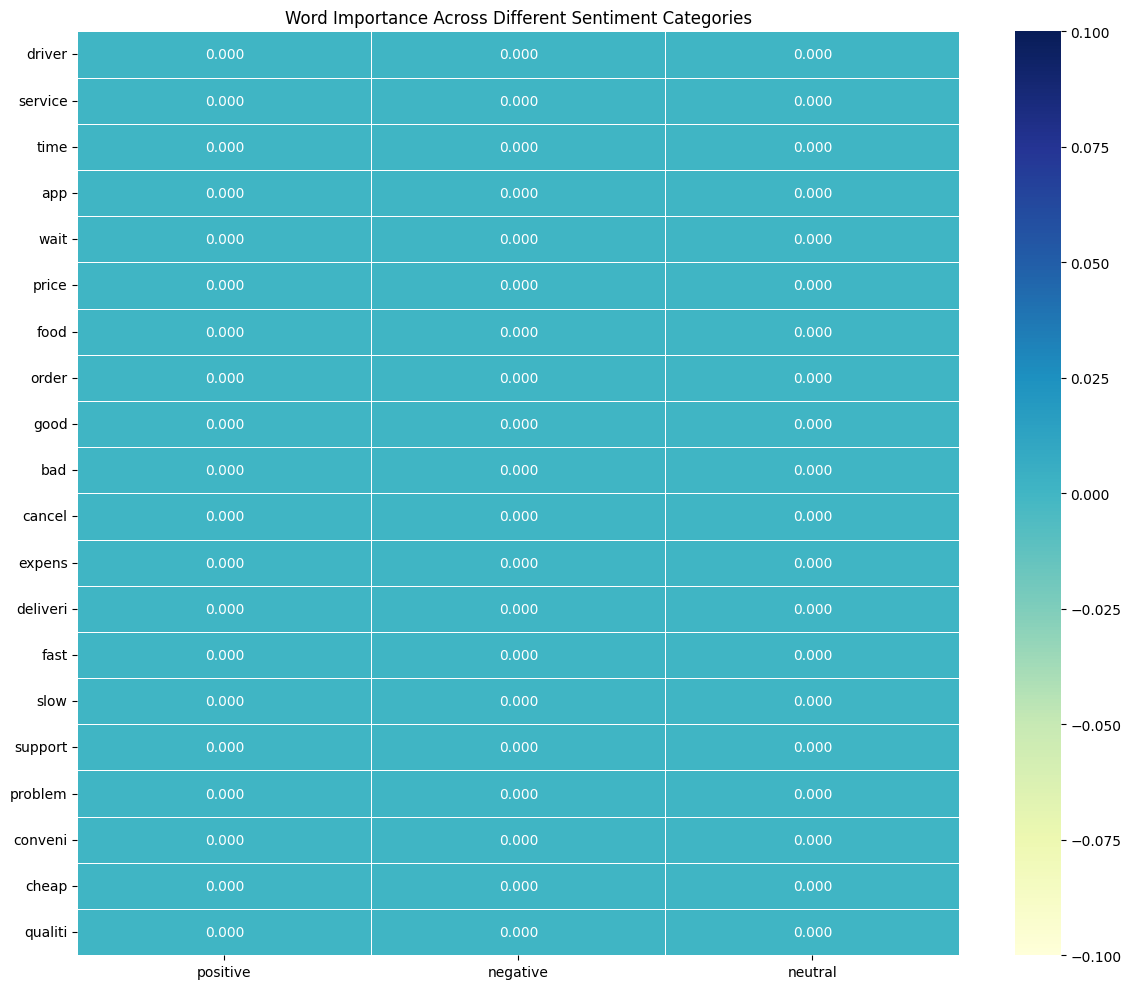

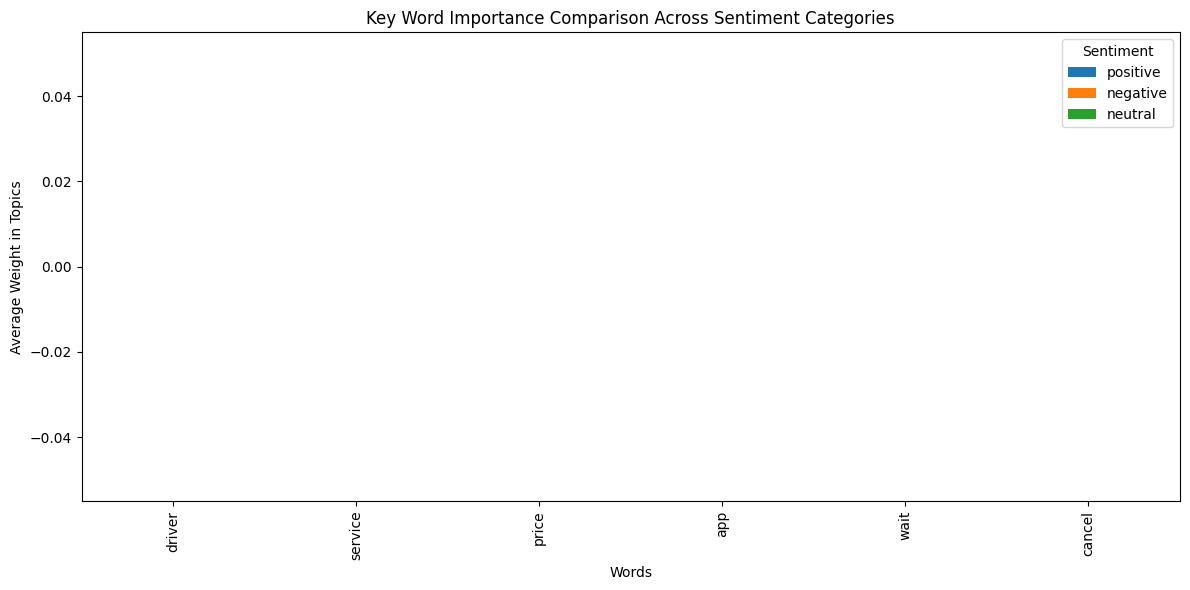

In [35]:
# Create DataFrame for plotting
comp_df = pd.DataFrame(word_comparison, index=comparison_words)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(comp_df, cmap='YlGnBu', annot=True, fmt='.3f', linewidths=.5)
plt.title('Word Importance Across Different Sentiment Categories')
plt.tight_layout()
plt.show()

# Plot bar chart for selected key words
key_words = ['driver', 'service', 'price', 'app', 'wait', 'cancel']
key_comp_df = comp_df.loc[key_words]

key_comp_df.plot(kind='bar', figsize=(12, 6))
plt.title('Key Word Importance Comparison Across Sentiment Categories')
plt.xlabel('Words')
plt.ylabel('Average Weight in Topics')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

### Key Findings from Sentiment-Based Topic Analysis

The topic modeling analysis reveals distinct thematic patterns across positive, negative, and neutral sentiments:

#### Positive Sentiment Topics
- **Service Excellence**: Driver professionalism and service quality emerge as primary satisfaction drivers
- **App Usability**: Customers frequently praise the intuitive interface and convenience
- **Delivery Reliability**: Timely food delivery and efficient service receive consistent recognition
- **Value for Money**: Competitive pricing and promotions are viewed favorably

#### Negative Sentiment Topics
- **Driver Issues**: Cancellations, extended wait times, and driver behavior dominate complaints
- **Pricing Complaints**: High fares, surge pricing, and unexpected charges appear frequently
- **Technical Problems**: App crashes, bugs, and location inaccuracies frustrate users
- **Customer Service**: Slow response times and resolution difficulties generate dissatisfaction

#### Neutral Sentiment Topics
- **Average Service**: Basic functionality meeting expectations without impressive features
- **Balanced Feedback**: Recognition of both positive aspects and areas for improvement
- **Price-Value Assessment**: Observations about reasonable but not exceptional pricing
- **Mixed Experiences**: Inconsistent experiences across different service components

The analysis shows that service quality and driver experience are critical factors across all sentiment categories, but context differs dramatically (excellence vs. problems). Price sensitivity appears more prominently in negative reviews, while convenience and ease of use dominate positive feedback.

### Task 5: Joint Analysis and Conclusion
Relationships between Sentiment and Topics

From our topic modeling analysis, we can observe several interesting patterns across different sentiment categories:

1. **Positive Reviews** tend to focus on convenience, service quality, and reliability of the Grab platform. Users frequently mention good experiences with drivers, prompt service, and ease of use.

2. **Negative Reviews** predominantly center around customer service issues, cancellations, long wait times, and pricing concerns. Technical problems with the app and payment difficulties also appear frequently.

3. **Neutral Reviews** contain mixed feedback, often acknowledging both positive aspects and areas for improvement. These reviews typically mention specific features without strong emotional language.

 Summary of Findings

1. **Service Quality is Key**: Driver behavior and service reliability emerge as critical factors that determine customer satisfaction.

2. **Price Sensitivity**: Pricing appears frequently in negative reviews, suggesting that customers are highly sensitive to fare changes and unexpected charges.

3. **App Functionality**: Technical aspects of the platform significantly impact user experience, with app crashes and bugs frequently mentioned in negative reviews.

4. **Response Time**: Wait times and driver availability are consistently mentioned across sentiment categories, indicating their importance to the overall customer experience.

Implications for Grab

Based on our analysis, Grab should consider:

1. **Driver Training**: Invest in driver quality and service standards to maintain positive experiences.

2. **Price Transparency**: Improve fare transparency and notification systems for any pricing changes or surcharges.

3. **Technical Reliability**: Prioritize app stability and address common technical issues that frustrate users.

4. **Customer Service**: Enhance customer support response times and resolution processes, particularly for cancellations and refunds.

5. **Waiting Experience**: Improve user experience during waiting periods through better ETA predictions and notifications.

By addressing these key areas, Grab could significantly improve customer satisfaction, potentially converting neutral and negative sentiments to positive ones.